In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5757c000 @  0x7f252f7b82a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [13]:
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

### Downloading and organizing script for conference room dataset 

In [ ]:
!git clone https://github.com/fyu/lsun.git
!python2.7 lsun/download.py -c conference_room
!unzip conference_room_train_lmdb
!unzip conference_room_val_lmdb
!mkdir data
!mv conference_room_train_lmdb data
!mv conference_room_val_lmdb data

Archive:  conference_room_train_lmdb.zip
   creating: conference_room_train_lmdb/
  inflating: conference_room_train_lmdb/lock.mdb  
  inflating: conference_room_train_lmdb/data.mdb  
mv: cannot stat 'conference_room_val_lmdb': No such file or directory


### Downloading and organizing script for the FOOD-101

In [ ]:
!wget "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
!tar -xvzf food-101.tar.gz

--2019-01-05 12:21:33--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-01-05 12:21:34--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  1.27MB/s    in 60m 55s 

2019-01-05 13:22:29 (1.30 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



### Downloading and organizing script for the IMAGENET

In [ ]:
mkdir train && mv ILSVRC2012_img_train.tar train/ && cd train
tar -xvf ILSVRC2012_img_train.tar && rm -f ILSVRC2012_img_train.tar
find . -name "*.tar" | while read NAME ; do mkdir -p "${NAME%.tar}"; tar -xvf "${NAME}" -C "${NAME%.tar}"; rm -f "${NAME}"; done
cd ..

In [ ]:
#parser = argparse.ArgumentParser()
#parser.add_argument('--dataset', required=True, help='cifar10 | lsun | mnist |imagenet | folder | lfw | fake')
#parser.add_argument('--dataroot', required=True, help='path to dataset')
#parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
#parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
#parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
#parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
#parser.add_argument('--ngf', type=int, default=64)
#parser.add_argument('--ndf', type=int, default=64)
#parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
#parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
#parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
#parser.add_argument('--cuda', action='store_true', help='enables cuda')
#parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
#parser.add_argument('--netG', default='', help="path to netG (to continue training)")
#parser.add_argument('--netD', default='', help="path to netD (to continue training)")
#parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
#parser.add_argument('--manualSeed', type=int, help='manual seed')

dataset_name = 'folder'
dataroot = 'food-101'
workers = 2
batchSize = 64
imageSize = 64
nz = 100
ngf = 64
ndf = 64
niter = 25
lr = 0.0002
beta1 = 0.5
ngpu = 1
netGPath = ''
netDPath = ''
outf = ''
torch.manual_seed(1)

cudnn.benchmark = True

    
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if dataset_name in ['imagenet', 'folder', 'lfw']:
    # folder dataset
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.CenterCrop(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    nc=3
elif dataset_name == 'lsun':
    dataset = dset.LSUN(root=dataroot, classes=['conference_room_train'],
                        transform=transforms.Compose([
                            transforms.Resize(imageSize),
                            transforms.CenterCrop(imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
    nc=3
elif dataset_name == 'cifar10':
    dataset = dset.CIFAR10(root=dataroot, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    nc=3

elif dataset_name == 'mnist':
        dataset = dset.MNIST(root=dataroot, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))
        nc=1

elif dataset_name == 'fake':
    dataset = dset.FakeData(image_size=(3, imageSize, imageSize),
                            transform=transforms.ToTensor())
    nc=3
print(dataset)

Dataset ImageFolder
    Number of datapoints: 101000
    Root Location: food-101
    Transforms (if any): Compose(
                             Resize(size=64, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(64, 64))
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [14]:
#assert dataset
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
#                                         shuffle=True, num_workers=int(workers))
workers = 2
batchSize = 64
imageSize = 64
nz = 100
ngf = 64
ndf = 64
niter = 25
lr = 0.0002
beta1 = 0.5
ngpu = 0
nc = 3
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
ngpu = int(ngpu)
nz = int(nz)
ngf = int(ngf)
ndf = int(ndf)


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

cpu


In [15]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netGPath = '../data/netG_epoch24_conference.pth'
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if netGPath != '':
    netG.load_state_dict(torch.load(netGPath))
print(netG)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

       	self.conv_1 = nn.Sequential( 
       		# input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            )
       	
       	self.conv_2 = nn.Sequential(
       		 # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
       		)
       	
       	self.conv_3 = nn.Sequential(
       		# state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
            )

       	self.conv_4 = nn.Sequential(
       		# state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
       		)

       	self.conv_5_sigmoid = nn.Sequential(
       		# state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
       		)

        # self.main = nn.Sequential(
        #     # input is (nc) x 64 x 64
        #     nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. (ndf) x 32 x 32
        #     nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ndf * 2),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. (ndf*2) x 16 x 16
        #     nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ndf * 4),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. (ndf*4) x 8 x 8
        #     nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ndf * 8),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. (ndf*8) x 4 x 4
        #     nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        #     nn.Sigmoid()
        # )

    def forward(self, input):
    	
        output = self.conv_1(input)
        output = self.conv_2(output)
        output = self.conv_3(output)
        output = self.conv_4(output)
        output = self.conv_5_sigmoid(output)

        # if input.is_cuda and self.ngpu > 1:
        #     output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        # else:
        #     output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
    def extract_features(self, input):
        out_1 = self.conv_1(input)
        out_2 = self.conv_2(out_1)
        out_3 = self.conv_3(out_2)
        out_4 = self.conv_4(out_3)

        max_pool_1 = nn.MaxPool2d(int(out_1.size(2) / 4))
        max_pool_2 = nn.MaxPool2d(int(out_2.size(2) / 4))
        max_pool_3 = nn.MaxPool2d(int(out_3.size(2) / 4))
        max_pool_4 = nn.MaxPool2d(int(out_4.size(2) / 4))
        
        out_1 = max_pool_1(out_1)
        out_2 = max_pool_2(out_2)
        out_3 = max_pool_3(out_3)
        out_4 = max_pool_4(out_4)
        print(out_1.size(), out_2.size(), out_3.size(), out_4.size())

        
        out_1 = out_1.view(out_1.size(0), -1).squeeze(1)
        out_2 = out_2.view(out_2.size(0), -1).squeeze(1)
        out_3 = out_3.view(out_3.size(0), -1).squeeze(1)
        out_4 = out_4.view(out_4.size(0), -1).squeeze(1)
        print(out_1.size(), out_2.size(), out_3.size(), out_4.size())

        output = torch.cat((out_1, out_2, out_3, out_4), 1)
        print(output.size())
        return output


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if netDPath != '':
    netD.load_state_dict(torch.load(netDPath))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [15]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload
device

    100% |████████████████████████████████| 5.7MB 8.0MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.


device(type='cuda', index=0)

In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0: 
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/25][0/1579] Loss_D: 1.6458 Loss_G: 5.9732 D(x): 0.5132 D(G(z)): 0.4913 / 0.0040
[0/25][100/1579] Loss_D: 0.3702 Loss_G: 8.7651 D(x): 0.8923 D(G(z)): 0.1503 / 0.0002
[0/25][200/1579] Loss_D: 0.7692 Loss_G: 6.6412 D(x): 0.9666 D(G(z)): 0.4194 / 0.0019
[0/25][300/1579] Loss_D: 0.0878 Loss_G: 5.7863 D(x): 0.9733 D(G(z)): 0.0563 / 0.0038
[0/25][400/1579] Loss_D: 0.7717 Loss_G: 6.0496 D(x): 0.8882 D(G(z)): 0.3959 / 0.0036
[0/25][500/1579] Loss_D: 0.4295 Loss_G: 2.6127 D(x): 0.8205 D(G(z)): 0.1516 / 0.1271
[0/25][600/1579] Loss_D: 0.3510 Loss_G: 4.2467 D(x): 0.8777 D(G(z)): 0.1786 / 0.0185
[0/25][700/1579] Loss_D: 2.4909 Loss_G: 6.6034 D(x): 0.1738 D(G(z)): 0.0008 / 0.0139
[0/25][800/1579] Loss_D: 0.5943 Loss_G: 4.8735 D(x): 0.9447 D(G(z)): 0.3671 / 0.0119
[0/25][900/1579] Loss_D: 0.2647 Loss_G: 5.5371 D(x): 0.8159 D(G(z)): 0.0220 / 0.0057
[0/25][1000/1579] Loss_D: 0.5423 Loss_G: 10.9371 D(x): 0.9268 D(G(z)): 0.2915 / 0.0000
[0/25][1100/1579] Loss_D: 0.4839 Loss_G: 3.1718 D(x): 0.7367 D(G(

# Forward pass through the trained generator

In [ ]:
def show_result(num_epoch, images, size_figure_grid = 8, show = False, save = False, path = 'result.png', isFix=False):
    
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(15, 15))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    
    images = (images + 1)/2
    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(images[k, :].cpu().data.numpy().transpose((1, 2, 0)))

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

torch.Size([64, 3, 64, 64])


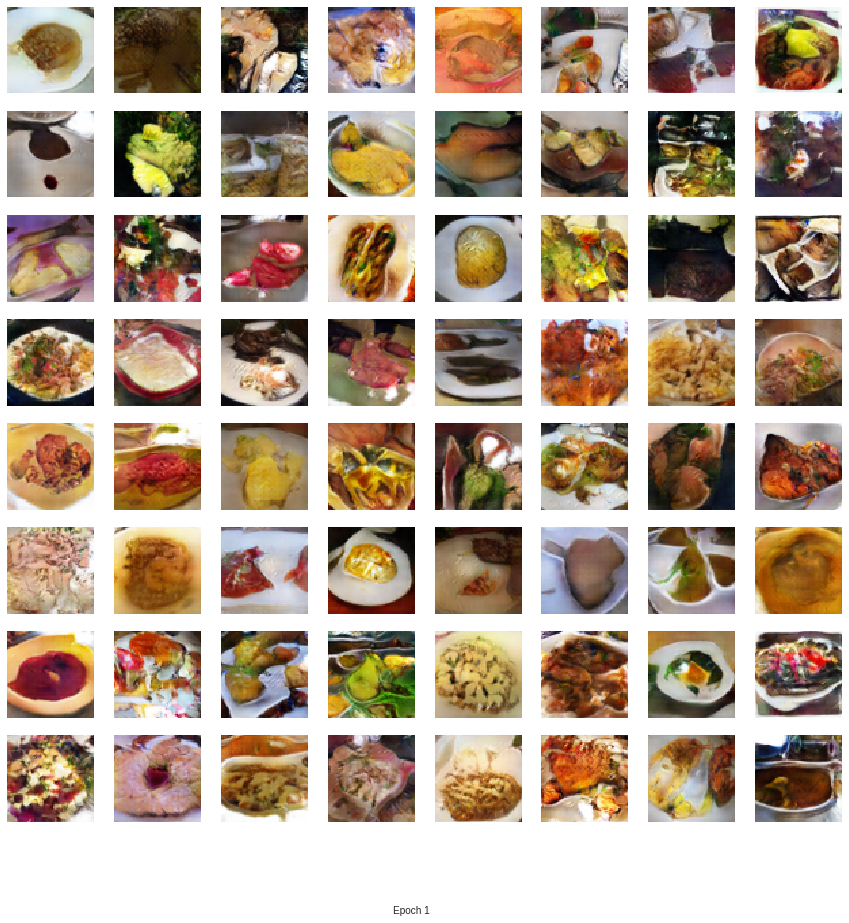

In [57]:
size = 64
torch.manual_seed(1)
noise = torch.randn(size, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(noise)
    print(fake.size())
    vutils.save_image(fake.detach(),
                    '%s/fake.png' % (''),
                    normalize=True)
show_result(1, fake.detach(), show=True)

#### Taking some random noise and averaging and showing img

In [ ]:
def average_noise(noise, idx):
    average_noise = torch.zeros((100, 1, 1), device = device)
    for i in idx:
        average_noise += noise[i, :]

    average_noise = average_noise/len(idx)
    return average_noise 

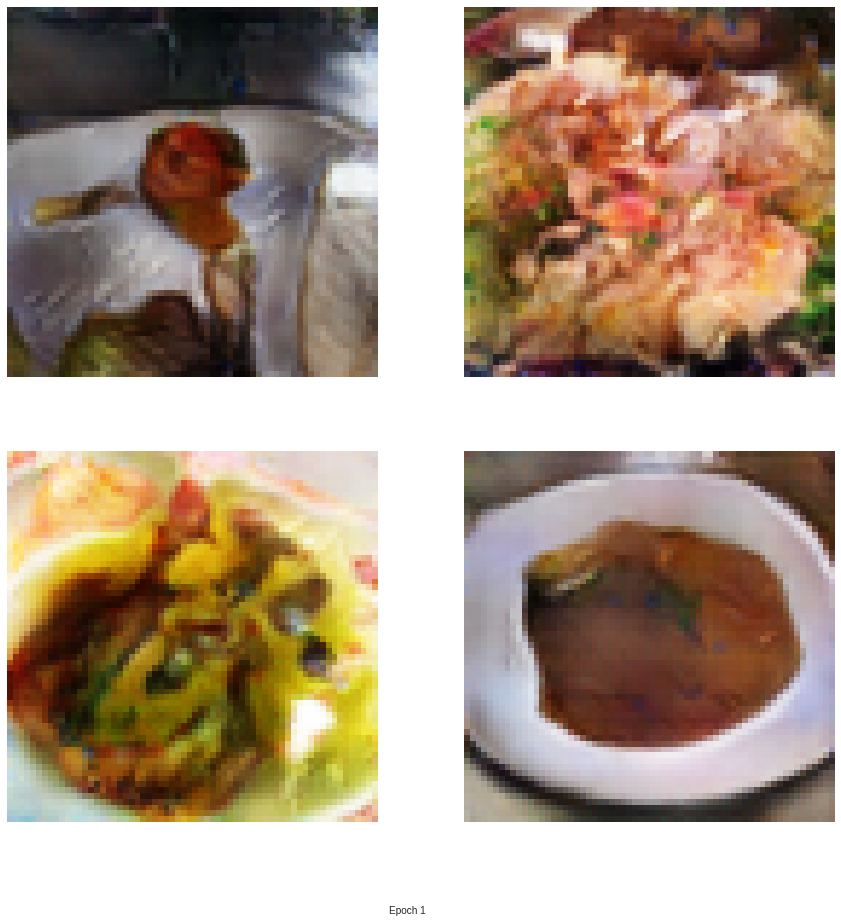

In [77]:
avg_noises = torch.zeros((4, 100, 1, 1), device = device)
avg_noises[0] = average_noise(noise, [5, 8, 10])
avg_noises[1] = average_noise(noise, [2, 30, 24])
avg_noises[2] = average_noise(noise, [19, 7, 58])
avg_noises[3] = average_noise(noise, [28, 48, 20])

## do some plus minus ... 
fake = netG(avg_noises)
show_result(1, fake, size_figure_grid=2, show=True)